<a href="https://colab.research.google.com/github/artemkavara/Deep-Learning-KPI/blob/main/Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторна робота №4

Варіант №6. Етап виконання роботи - 3

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [ ]:
import zipfile

In [ ]:
import re
import os
import shutil

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras import layers

In [ ]:
from keras import backend

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

# Дані

Будемо використовувати набір даних, який був представлений під час навчання мережі Inception v3. Це датасет, який містить 10000 фотографій літаків. Будемо вчитися генерувати літаки різних моделей. У цілому, тут є 4 основних категорії класів: модель літака (наприклад, Boeing 737-76J), варіант (Boeing 737-700), сім'я літака (Boeing 737) та фірма (Boeing).

## Завантаження даних

In [ ]:
!wget https://data.deepai.org/FGVCAircraft.zip 

--2021-05-29 02:59:54--  https://data.deepai.org/FGVCAircraft.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2754361826 (2.6G) [application/zip]
Saving to: ‘FGVCAircraft.zip’

FGVCAircraft.zip    100%[===================>]   2.56G  20.7MB/s    in 2m 7s   

2021-05-29 03:02:02 (20.6 MB/s) - ‘FGVCAircraft.zip’ saved [2754361826/2754361826]



In [ ]:
zip_source = "/content/FGVCAircraft.zip"
zip_ref = zipfile.ZipFile(zip_source, 'r')
zip_ref.extractall('/content')
zip_ref.close()

## Формування даних

In [ ]:
train_images, train_labels = [], []

with open("/content/fgvc-aircraft-2013b/data/images_manufacturer_train.txt", "r") as f:
  for line in f.readlines():
    temp_im, temp_lbl = re.match(r"\d+", line).group(0), line[8:-1]
    train_images.append(temp_im)
    train_labels.append(temp_lbl)

In [ ]:
valid_images, valid_labels = [], []

with open("/content/fgvc-aircraft-2013b/data/images_manufacturer_val.txt", "r") as f:
  for line in f.readlines():
    temp_im, temp_lbl = re.match(r"\d+", line).group(0), line[8:-1]
    valid_images.append(temp_im)
    valid_labels.append(temp_lbl)

In [ ]:
#shutil.rmtree("/content/train_air")
#shutil.rmtree("/content/test_air")
#shutil.rmtree("/content/valid_air")

In [ ]:
test_images, test_labels = [], []

with open("/content/fgvc-aircraft-2013b/data/images_manufacturer_test.txt", "r") as f:
  for line in f.readlines():
    temp_im, temp_lbl = re.match(r"\d+", line).group(0), line[8:-1]
    test_images.append(temp_im)
    test_labels.append(temp_lbl)

In [ ]:
!mkdir /content/train_air
!mkdir /content/valid_air
!mkdir /content/test_air

In [ ]:
!mkdir /content/train_air/air
!mkdir /content/valid_air/air
!mkdir /content/test_air/air

In [ ]:
'''for label in set(train_labels):
  if label not in ["Airbus", "Cessna", "Embraer"]:
    continue
  os.mkdir(f"/content/train_air/{label}")
  os.mkdir(f"/content/valid_air/{label}")
  os.mkdir(f"/content/test_air/{label}")'''

'for label in set(train_labels):\n  if label not in ["Airbus", "Cessna", "Embraer"]:\n    continue\n  os.mkdir(f"/content/train_air/{label}")\n  os.mkdir(f"/content/valid_air/{label}")\n  os.mkdir(f"/content/test_air/{label}")'

In [ ]:
for image, label in zip(train_images, train_labels):
  shutil.copy(f"/content/fgvc-aircraft-2013b/data/images/{image}.jpg", f"/content/train_air/air/{image}.jpg")

In [ ]:
for image, label in zip(test_images, test_labels):
  shutil.copy(f"/content/fgvc-aircraft-2013b/data/images/{image}.jpg", f"/content/train_air/air/{image}.jpg")

In [ ]:
for image, label in zip(valid_images, valid_labels):
  shutil.copy(f"/content/fgvc-aircraft-2013b/data/images/{image}.jpg", f"/content/valid_air/air/{image}.jpg")

## Приклад даних

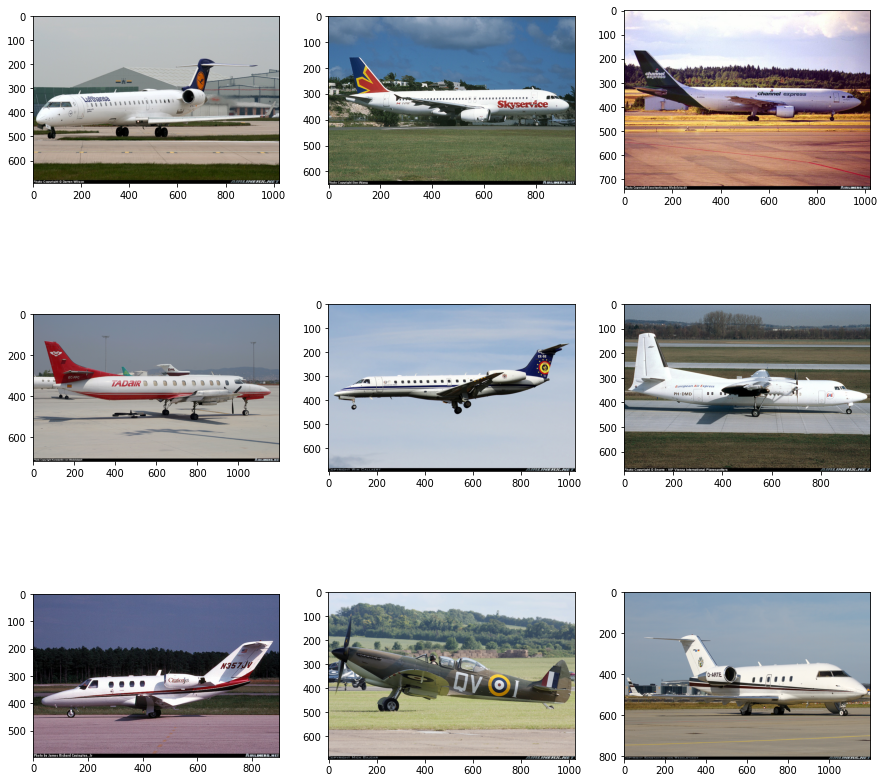

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(15,15))
for i, a in enumerate(ax):
  for j, _a in enumerate(a):
    dir = "/content/train_air/air"
    img = random.sample(os.listdir(dir), 1)
    img_plot = mpimg.imread(dir+"/"+img[0])
    _a.imshow(img_plot)

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255.)

In [ ]:
train_data = datagen.flow_from_directory(
      "/content/train_air",
      (120, 200),
      "rgb",
      batch_size = 64,
      class_mode = 'input'
  )

valid_data = datagen.flow_from_directory(
      "/content/valid_air",
      (120, 200),
      "rgb",
      batch_size = 64,
      class_mode = 'input'
  )

Found 6667 images belonging to 1 classes.
Found 3333 images belonging to 1 classes.


# Проектування варіаційного автокодувальника

## Побудова кодувальника

In [ ]:
def get_code_from_a_and_sigma(args):
  a, sigma_sq = args
  batch = backend.shape(a)[0]
  dim = backend.int_shape(sigma_sq)[1]
  eps = backend.random_normal(shape=(batch, dim))
  return a + backend.exp(sigma_sq / 2) * eps

In [ ]:
shape = (120, 200, 3)
conv_shape = (3, 5)
num_hidden_dense = 32
num_sample = 16

In [ ]:
init = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')

In [ ]:
inp = layers.Input(shape = shape, name = "Input")
x = layers.Conv2D(16, conv_shape, padding = "same",
                  activation = "elu", name = "conv_1_en") (inp)
x = layers.BatchNormalization(name = "batch_1_en") (x)
x = layers.Conv2D(32, conv_shape, padding = "same", 
                  activation = "elu", name = "conv_2_en") (x)
x = layers.BatchNormalization(name = "batch_2_en") (x)
x = layers.Conv2D(64, conv_shape, padding = "same", 
                  activation = "elu", name = "conv_3_en") (x)
x = layers.BatchNormalization(name = "batch_3_en") (x)
shape_new = backend.int_shape(x)

x = layers.Flatten(name = "flatten_en")(x)
x = layers.Dense(num_hidden_dense, activation="elu", name = "dense_en") (x)
x = layers.BatchNormalization(name = "batch_4_en")(x)

a = layers.Dense(num_sample, name = "a_en") (x)
sigma = layers.Dense(num_sample, name = "sigma_en") (x)

z = layers.Lambda(get_code_from_a_and_sigma, output_shape=(num_sample, ), name='z')([a, sigma])
encoder = tf.keras.Model(inp, [a, sigma, z], name='encoder')

## Побудова декодувальника

In [ ]:
dec_inp = layers.Input(shape = (num_sample,), name = "dec_inp")
dec_x = layers.Dense(num_hidden_dense,activation="elu", name = "dense_1_dec") (dec_inp) 
dec_x = layers.BatchNormalization(name = "batch_1_dec") (dec_x)
dec_x = layers.Dense(shape_new[1] * shape_new[2] * shape_new[3], activation="elu", name = "dense_2_dec")(dec_x)

dec_x = layers.Reshape((shape_new[1], shape_new[2], shape_new[3]), name = "reshape_dec" )(dec_x)

dec_x = layers.BatchNormalization(name = "batch_2_dec")(dec_x)
dec_x = layers.Conv2DTranspose(64, conv_shape, padding='same', activation="elu", name = "conv_1_dec")(dec_x)

dec_x = layers.BatchNormalization(name = "batch_3_dec")(dec_x)
dec_x = layers.Conv2DTranspose(32, conv_shape, padding='same',  activation="elu", name = "conv_2_dec")(dec_x)
dec_x = layers.BatchNormalization(name = "batch_4_dec")(dec_x)
dec_x = layers.Conv2DTranspose(16, conv_shape, padding='same',  activation="elu", name = "conv_3_dec")(dec_x)
out = layers.Conv2DTranspose(shape[2], conv_shape, activation='sigmoid', padding='same', name='decoder_output')(dec_x)

decoder = tf.keras.Model(dec_inp, out, name='decoder')

## Автокодувальник

In [ ]:
autoencoder_out = decoder(encoder(inp)[2])
autoencoder = tf.keras.Model(inp, autoencoder_out, name='vae')
autoencoder.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 120, 200, 3)]     0         
_________________________________________________________________
encoder (Functional)         [(None, 16), (None, 16),  49192896  
_________________________________________________________________
decoder (Functional)         (None, 120, 200, 3)       50789987  
Total params: 99,982,883
Trainable params: 99,982,211
Non-trainable params: 672
_________________________________________________________________


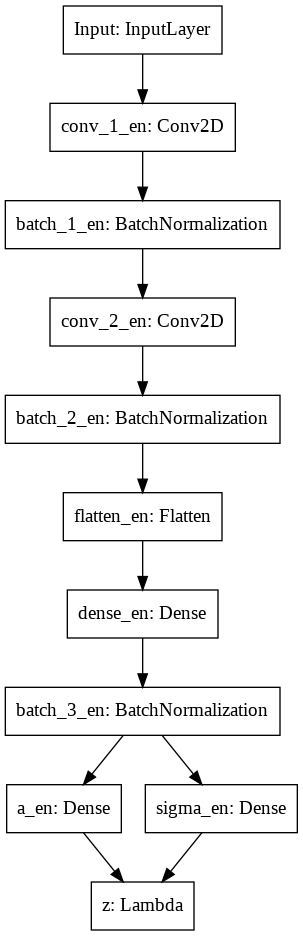
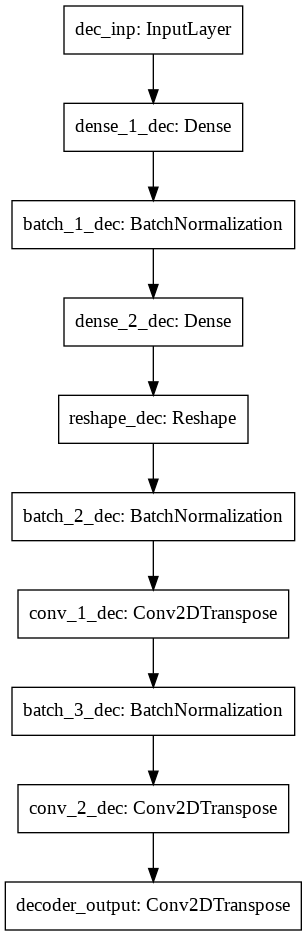

## Втрата Кульбака-Лайблера

In [ ]:
eps = 1e-10
latent_loss = 0.5 * tf.reduce_sum(tf.square(sigma) + tf.square(a) - 1 - backend.log(eps+tf.square(sigma)))

## Втрата реконструкції

In [ ]:
reconstruction_loss = tf.metrics.mse(inp, autoencoder_out)*120*200*3

## Загальна втрата

In [ ]:
loss = reconstruction_loss+latent_loss

In [ ]:
autoencoder.add_loss(loss)

## Компіляція моделі

In [ ]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam())

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

## Тренування

In [ ]:
with tf.device("/device:GPU:0"):
  history = autoencoder.fit(
    train_data,
    validation_data=valid_data,
    epochs=30,
    callbacks = [callback]
  )

Epoch 1/30
105/105 [==============================] - 175s 2s/step - loss: 4583.5640 - val_loss: 4328.4829
Epoch 2/30
105/105 [==============================] - 171s 2s/step - loss: 3870.6592 - val_loss: 4350.8271
Epoch 3/30
105/105 [==============================] - 170s 2s/step - loss: 3731.2498 - val_loss: 4150.8052
Epoch 4/30
105/105 [==============================] - 170s 2s/step - loss: 3700.0566 - val_loss: 3827.5750
Epoch 5/30
105/105 [==============================] - 169s 2s/step - loss: 3634.8298 - val_loss: 4065.1062
Epoch 6/30
105/105 [==============================] - 169s 2s/step - loss: 3525.1143 - val_loss: 3753.1497
Epoch 7/30
105/105 [==============================] - 170s 2s/step - loss: 3459.0149 - val_loss: 3506.1375
Epoch 8/30
105/105 [==============================] - 170s 2s/step - loss: 3511.7639 - val_loss: 3936.6050
Epoch 9/30
105/105 [==============================] - 170s 2s/step - loss: 3414.8364 - val_loss: 3320.9675
Epoch 10/30
105/105 [================

In [ ]:
def plot_res(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, label = "Train")
  plt.plot(epochs, val_loss, label = "Validation")
  plt.title('Training and validation loss')
  plt.legend()

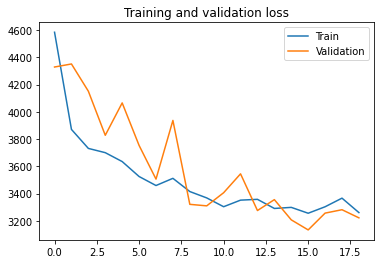

In [ ]:
plot_res(history)

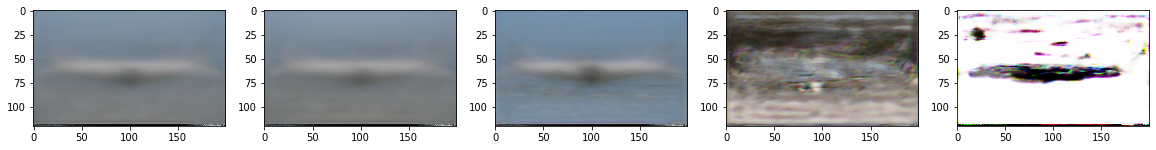

In [ ]:
fig, ax = plt.subplots(1, 5, figsize = (20, 10))
for i in range(5):
  rand_vec = tf.random.normal(
    (1,num_sample), mean=0.0, stddev = 0.001*10**(i+1), dtype=tf.dtypes.float32,
  )
  gen_img = decoder.predict(rand_vec)
  ax[i].imshow(gen_img[0])

plt.savefig("fig_6_0.png")

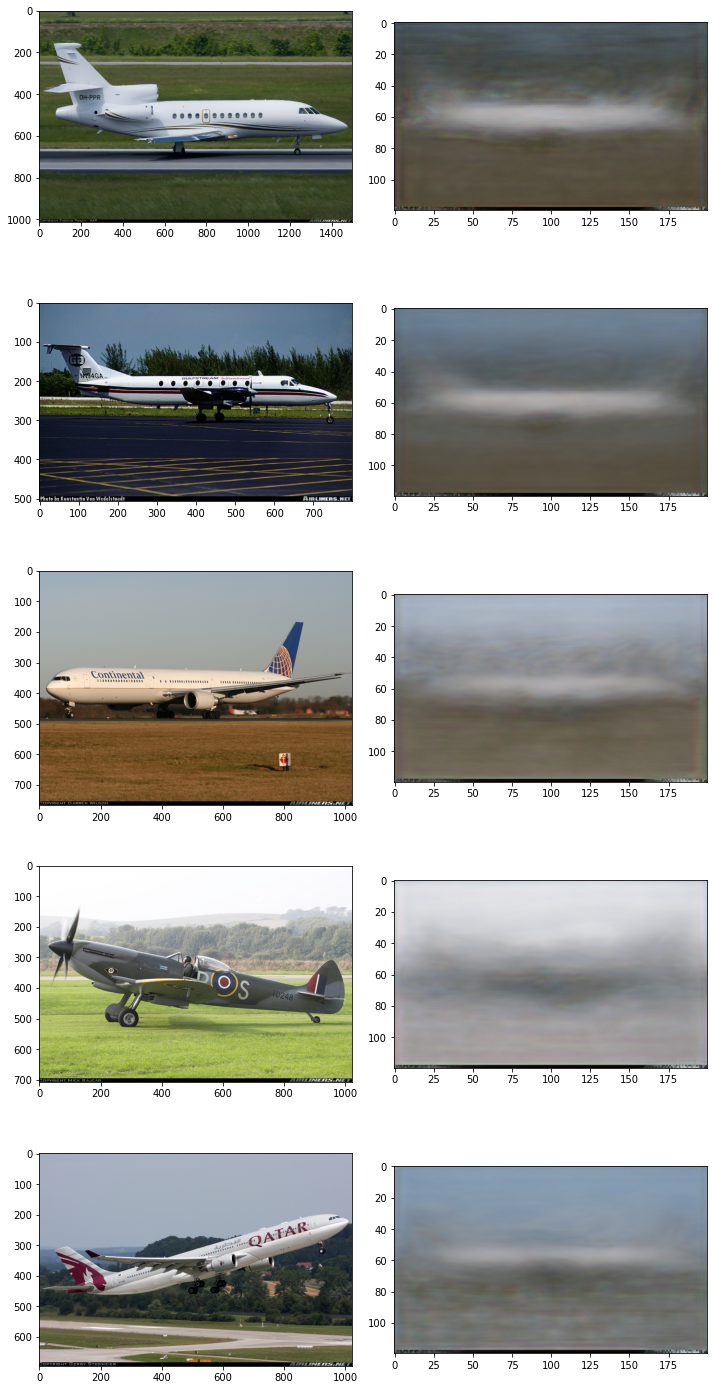

In [ ]:
fig, ax = plt.subplots(ncols=2,nrows = 5, figsize = (10, 20))
fig.tight_layout()
dir = "/content/valid_air/air"
for i in range(5):
  img_path = random.sample(os.listdir(dir), 1)[0]
  img = load_img(dir+"/"+img_path, target_size=(120, 200), color_mode="rgb") 
  x = img_to_array(img)/255
  encoder_output = encoder.predict(x.reshape(1, 120, 200, 3))[2]
  decoder_output = decoder.predict(encoder_output)[0]
  img_plot = mpimg.imread(dir+"/"+img_path)
  ax[i][0].imshow(img_plot)
  ax[i][1].imshow(decoder_output)

plt.savefig("fig_6.png")